In [1]:
import numpy as np
from scipy.interpolate import interp1d, interp2d
import matplotlib.pyplot as plt
import numpy.linalg as lin

import sys
sys.path.append("..")

from PDEsolve.PDEsolver import *

import pypesto
import pypesto
import pypesto.optimize as optimize
import pypesto.sample as sample
import pypesto.visualize as visualize
import pypesto.profile as profile

3.42125 39.333333333333336


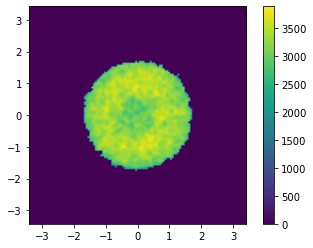

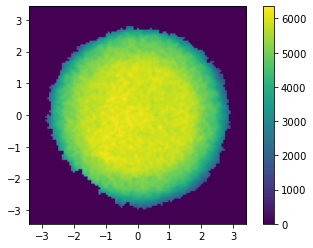

In [2]:
rhoexp = np.load('dataZenodo.npy') # averaged data from zenodo

Lexp = (rhoexp.shape[0]/2)*115/1000/2
tmax = rhoexp.shape[-1]*20/60
print(Lexp,tmax)
dxexp = Lexp/(rhoexp.shape[0]/2)
tspan = np.linspace(0,tmax,rhoexp.shape[-1])
dtexp = tspan[1] - tspan[0]

plt.imshow(rhoexp[:,:,0],extent = [-Lexp,Lexp,-Lexp,Lexp])
plt.colorbar()
plt.show()

plt.imshow(rhoexp[:,:,-1],extent = [-Lexp,Lexp,-Lexp,Lexp])
plt.colorbar()
plt.show()

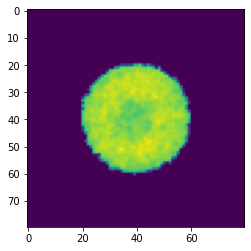

In [4]:
# Define interpolation to compare with model

Nx = 40
Ny = 40
Lx = Lexp
Ly = Lexp
dt = dtexp
dx = Lx/Nx
dy = Ly/Ny
xspan = np.linspace(-Lx + dx/2, Lx - dx/2, int(2*Nx))
yspan = np.linspace(-Ly + dy/2, Ly - dy/2, int(2*Ny))

X,Y = np.meshgrid(xspan,yspan)

xe = np.linspace(-Lx,Ly,rhoexp.shape[0])
ye = np.linspace(-Lx,Ly,rhoexp.shape[1])



fun = interp2d(xe,ye,rhoexp[:,:,0])

init_rho = fun(xspan,yspan)

plt.imshow(init_rho)
plt.show()

In [5]:
solve_fun = lambda D,r,pmax: fisher_1species(Lx,Ly,Nx,Ny,dt,init_rho,tmax,D,r,pmax)
#solve_fun = lambda D,r,pmax: porous_1species(Lx,Ly,Nx,Ny,dt,init_rho,tmax,D,r,pmax) for Porous-Fisher model

In [6]:
def dist_sol(rho): # Distance between rho and rhoexp
    indices = [-1,int(len(rhoexp)/2),int(3*len(rhoexp)/4),int(len(rhoexp)/4)]
    d = 0
    K = 0
    for i in indices:
        fun = interp2d(xe,ye,rhoexp[:,:,i])
        d += lin.norm(fun(xspan,yspan) - rho[i])**2
        K += 4*Nx*Ny
    return d,K
    

def objective_fun(x): # Objective function to minimize
    D,r,pmax, sigma = 10**x[0],10**x[1],10**x[2],10**x[3]
    solver = solve_fun(D,r,pmax)
    rhosol = solver.solve()
    if rhoexp.shape[-1] != len(rhosol):
        print('Warning: Dims of simulation and data do not match!')
    dist, K = dist_sol(rhosol)
    return 2*np.log(sigma)*K + dist/sigma**2

In [7]:
# Defining PESTO problem

lb = [-4,-2,3,2] # for Fisher-KPP
ub = [-1,0,4.4,3]

#lb = [-9,-3,3.1,1] # for Porous-Fisher
#ub = [-4.7,0.5,4.5,3.2]


objective = pypesto.Objective(fun=objective_fun)
problem = pypesto.Problem(objective=objective,  # objective function
                              lb=lb,  # lower bounds
                              ub=ub,  # upper bounds
                              x_names=['D', 'r', 'K','sigma'],  # parameter names
                              x_scales=['log10', 'log10', 'log10','log10'])

In [35]:
import pypesto.optimize as optimize

result = optimize.minimize(problem=problem, n_starts=20, filename=None)

  0%|                                                    | 0/20 [00:00<?, ?it/s]

  5%|██▏                                         | 1/20 [01:28<27:57, 88.30s/it]

 10%|████▍                                       | 2/20 [02:51<25:40, 85.59s/it]

 15%|██████▍                                    | 3/20 [05:26<33:10, 117.06s/it]

 20%|████████▌                                  | 4/20 [07:07<29:31, 110.73s/it]

 25%|██████████▊                                | 5/20 [09:34<30:57, 123.83s/it]

 30%|████████████▉                              | 6/20 [12:03<30:54, 132.46s/it]

 35%|███████████████                            | 7/20 [13:46<26:33, 122.61s/it]

 40%|█████████████████▏                         | 8/20 [15:14<22:20, 111.69s/it]

 45%|███████████████████▊                        | 9/20 [16:26<18:13, 99.40s/it]

 50%|█████████████████████▌                     | 10/20 [18:06<16:34, 99.44s/it]

 55%|███████████████████████▋                   | 11/20 [19:36<14:29, 96.66s/it]

 60%|█████████████████████████▊                 | 12/20 [20:50<11:56, 89.56s/it]

 65%|███████████████████████████▎              | 13/20 [23:18<12:30, 107.27s/it]

 70%|█████████████████████████████▍            | 14/20 [25:40<11:47, 117.93s/it]

 75%|███████████████████████████████▌          | 15/20 [27:29<09:35, 115.19s/it]

 80%|█████████████████████████████████▌        | 16/20 [30:32<09:02, 135.66s/it]

 85%|███████████████████████████████████▋      | 17/20 [32:17<06:19, 126.45s/it]

 90%|█████████████████████████████████████▊    | 18/20 [34:21<04:11, 125.61s/it]

 95%|███████████████████████████████████████▉  | 19/20 [36:35<02:08, 128.13s/it]

100%|██████████████████████████████████████████| 20/20 [38:15<00:00, 114.79s/it]

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

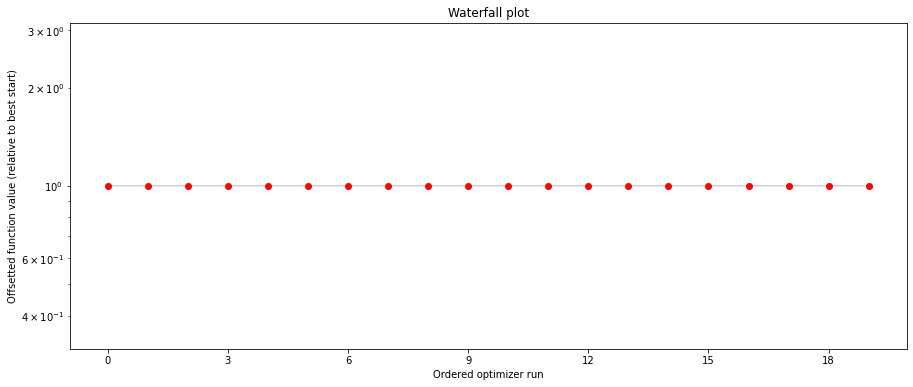

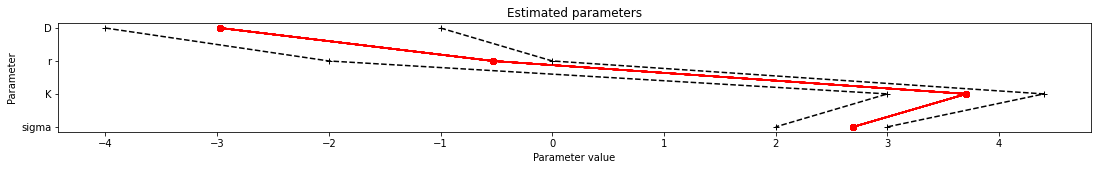

In [36]:
visualize.waterfall(result, size=(15, 6)) # Waterfall plot
visualize.parameters(result) # Visualize parameters

In [8]:
sampler = sample.AdaptiveMetropolisSampler()
resultMCMC = sample.sample(
    problem, n_samples=12000, sampler=sampler, filename=None, x0 = np.array([-3,-1,3.5,2]))

100%|███████████████████████████████████| 12000/12000 [1:47:46<00:00,  1.86it/s]
Elapsed time: 13214.656707


/opt/anaconda3/lib/python3.9/site-packages/pypesto/visualize/sampling.py:1271: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  warnings.warn(


array([[<AxesSubplot:xlabel='iteration index', ylabel='D'>,
        <AxesSubplot:xlabel='iteration index', ylabel='r'>],
       [<AxesSubplot:xlabel='iteration index', ylabel='K'>,
        <AxesSubplot:xlabel='iteration index', ylabel='sigma'>]],
      dtype=object)

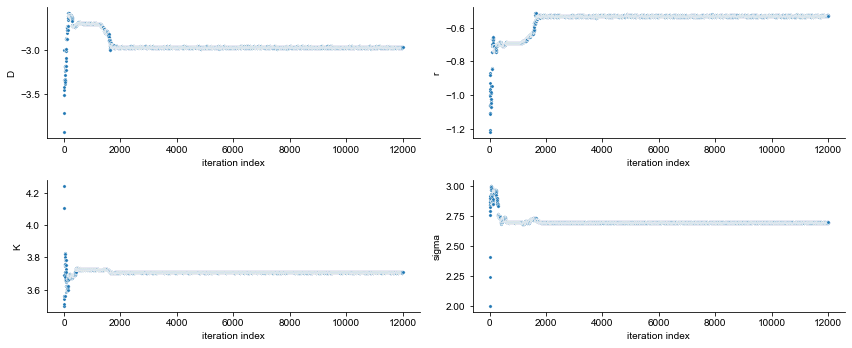

In [9]:
visualize.sampling_parameter_traces(resultMCMC, use_problem_bounds=False, size=(12, 5))